* Indexing method for making dictionary keys - DONE
* each position is an object with index but also list showing cRDS - DONE
* CAN PASS CARDS TO MC SO NO NEED TO BACK CONVERT. JUST USED AS A KEY. LIST IS USED FOR SCORING AND MC - DONE
* Create full list of positions - DONE
* Function to convert index keys to simulation inputs - DONE
* MC simulation - DONE
* Exact analytical solution
* Algo for using simulation to solve for strategy
* Compare analytical and numerical solution
* For playing games, the int indexes may just work. Just for strategy making they wont as those impossible hands are tehcnically possible. 


In [49]:
import random as rn
import numpy as np
import pandas as pd
import math
#Example index: 17000000001001
#Example_hand: [7,0,0,0,0,0,0,0,0,10,1]

In [50]:
def cardsToIndex(player_hand, dealer_card, draw = None):
    index_scaling = [10**11, 10**10, 10**9, 10**8, 10**7, 10**6, 10**5, 10**4, 10**2, 10**0]
    index = 10000000000000 + dealer_card*10**12
    if draw != None:
        player_hand[10 - draw] += 1
    for card in range(10):
        index += index_scaling[card] * player_hand[card]
    return index

In [51]:
def indexToCards(index):#TODO
    index = list(str(index)[1:])
    dealer_hand = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    dealer_hand[9 - int(index[0])] += 1
    index = index[1:]
    return [int(x) for x in index[0:-4] + [index[-4] + index[-3]] + [index[-2] + index[-1]]], dealer_hand

In [52]:
def score(player_cards):
    score = player_cards[-1] * 11
    high_aces = player_cards[-1]
    for cardIndex in range(9):
        score += (10 - cardIndex) * player_cards[cardIndex]
    #Determine whether to use aces as 1 or 11
    while score > 21 and high_aces > 0:
        if high_aces > 0:
            score -= 10
            high_aces -= 1
    return score 

In [53]:
def simulateGames(position, number_games = 1000):#TODO
    player_wins, dealer_wins, ties = 0, 0, 0
    dealer_card = position.dealer_face
    player_score = position.score
    draw_weights = np.array([x - y for x, y in zip([card*position.decks for card in [16, 4, 4, 4, 4, 4, 4, 4, 4, 4]], position.cards_in_play)])
    base_weights = []
    for i in range(10):
        base_weights += [10 - i]*draw_weights[i]

    base_dealer_hand = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    base_dealer_hand[10 - dealer_card] += 1

    while number_games > 0:
        temp_weights = base_weights.copy()
        dealer_hand = base_dealer_hand.copy()
        dealer_score = 0
        while dealer_score < 17:
            card = temp_weights.pop(rn.randint(0, len(temp_weights) - 1))
            dealer_hand[10 - card] += 1
            temp_weights[10 - card] -= 1
            dealer_score = score(dealer_hand)
        if player_score < 22:
            if player_score > dealer_score:
                player_wins += 1
            if player_score < dealer_score and dealer_score < 22:
                dealer_wins +=1
            if dealer_score > 21:
                player_wins +=1
            if player_score == dealer_score:
                ties += 1
        if player_score > 21:
            dealer_wins += 1

        number_games -= 1 
    return (player_wins - dealer_wins)/(player_wins + dealer_wins + ties)

In [54]:
def deckContents(position):
    return np.array([x - y for x, y in zip([card*position.decks for card in [16, 4, 4, 4, 4, 4, 4, 4, 4, 4]], position.cards_in_play)])

In [55]:
class Position:
    def __init__(self, index = None, cards = None, dealer_card = None, draw = None, decks = 1):
        if index != None:
            self.index = index
            self.player_hand, self.dealer_hand = indexToCards(self.index)
        if index == None:
            self.player_hand = cards
            self.dealer_hand = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
            self.dealer_hand[10 - dealer_card] += 1
            self.index = cardsToIndex(self.player_hand, dealer_card, draw)
        self.hand_size = len(self.player_hand)
        self.dealer_face = dealer_card
        self.score = score(self.player_hand)
        self.bust = True if self.score > 21 else False
        self.decks = decks

        self.cards_in_play = [x + y for x, y in zip(self.player_hand, self.dealer_hand)]

        self.valid = True if all(x < 4*self.decks + 1  for x in self.cards_in_play[1:]) and self.cards_in_play[0] < 16*self.decks + 1 else False

    def add_stick_probability(self, simulations):
        self.stick_probability = simulateGames(self, number_games = simulations)

    def analyticalSolution(self):
        deck_contents = deckContents(self)
        total_cards_in_deck = sum(deck_contents)
        Master = {}
        Next = {"".join(map(str, self.dealer_hand)): [self.dealer_hand, 1]}
        Depth = 0
        while len(Next) != 0:
            Current = Next.copy()
            Next = {}
            for hand_index in Current.keys():
                for drawn_card in range(1,11):
                    hand = Current[hand_index][0].copy()
                    comparison = hand.copy()#Improve this and next two lines :/
                    comparison[10 - self.dealer_face] -= 1
                    if comparison[10 - drawn_card] < deck_contents[10 - drawn_card]:
                        next_index_cards = hand.copy()
                        next_index_cards[10 - drawn_card] += 1
                        next_index = "".join(map(str, next_index_cards))
                        next_score = score(next_index_cards)
                        hand[10 - self.dealer_face] -= 1
                        if next_score < 17:
                            if next_index not in Next.keys():
                                Next[next_index] = [next_index_cards, 0]
                            Next[next_index][1] += Current[hand_index][1] * (deck_contents[10 - drawn_card] - hand[10 - drawn_card])/(total_cards_in_deck - Depth)
                        else:
                            if next_index not in Master.keys():
                                Master[next_index] = [0, next_score]
                            Master[next_index][0] += Current[hand_index][1] * (deck_contents[10 - drawn_card] - hand[10 - drawn_card])/(total_cards_in_deck - Depth)
            Depth += 1

        count = [0,0,0]
        score_outcomes = {}
        player_score = self.score
        for possible_dealer_score in range(17, 27):
            if (self.score < 22):
                if (self.score > possible_dealer_score):
                    score_outcomes[possible_dealer_score] = 0
                if self.score < possible_dealer_score and possible_dealer_score < 22:
                    score_outcomes[possible_dealer_score] =  1
                if (possible_dealer_score > 21):
                    score_outcomes[possible_dealer_score] = 0
                if (self.score == possible_dealer_score):
                    score_outcomes[possible_dealer_score] = 2
            else:
                score_outcomes[possible_dealer_score] = 1

        for check in Master.keys():
            count[score_outcomes[Master[check][1]]] += Master[check][0]

        self.analytic_stick_probability = (count[0] - count[1])/sum(count)
        self.error = self.analytic_stick_probability - self.stick_probability

In [56]:
def getPositions(decks = 1):
    Next = {10000000000000 : Position(index = 10000000000000, dealer_card = 1)}
    Master = {}
    runs = 0
    while len(Next) != 0:
        Current = Next
        Next = {}
        for position in Current.values():
            for drawn in range(1, 11):
                gate = True
                for dealer_card in range(1, 11):
                    temp = position.player_hand.copy()
                    current_position = Position(cards = temp, draw = drawn, dealer_card = dealer_card, decks = decks)
                    if not current_position.bust and current_position.valid:
                        if gate:
                            Next[current_position.index] = current_position
                            gate = False
                        if runs > 0:
                            Master[current_position.index] = current_position
        runs += 1
    return Master

In [57]:
class Strategy:
    def __init__(self, decks = 1):
        self.positions = getPositions(decks = decks)
    
    def get_stick_probability(self, simulations):
        for position in self.positions.values():
            position.add_stick_probability(simulations)

In [58]:
strategy = Strategy()
strategy.get_stick_probability(10000)

In [59]:
for i in strategy.positions.values():
    i.analyticalSolution()

In [60]:
vars(strategy.positions[11000000000002])

{'player_hand': [0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
 'dealer_hand': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 'index': 11000000000002,
 'hand_size': 10,
 'dealer_face': 1,
 'score': 12,
 'bust': False,
 'decks': 1,
 'cards_in_play': [0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
 'valid': True,
 'stick_probability': -0.7796,
 'analytic_stick_probability': -0.7731363901853265,
 'error': 0.006463609814673421}

In [61]:
errors = []
for i in strategy.positions.values():
    errors.append(i.error)

In [62]:
import matplotlib.pyplot as plt

(array([  1.,   0.,   2.,   2.,   0.,   4.,   5.,   3.,   7.,  10.,   8.,
         13.,  17.,  24.,  20.,  26.,  41.,  43.,  65.,  70.,  81., 106.,
        127., 142., 133., 205., 246., 292., 359., 396., 433., 500., 602.,
        680., 806., 890., 924., 962., 945., 892., 814., 774., 711., 622.,
        619., 558., 517., 466., 459., 419., 384., 349., 326., 293., 233.,
        237., 185., 196., 148., 153., 152., 125., 105.,  68.,  97.,  68.,
         77.,  48.,  53.,  38.,  42.,  36.,  31.,  24.,  14.,  23.,  10.,
         16.,  12.,   9.,   4.,  10.,   2.,   2.,   2.,   1.,   0.,   2.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,
          1.]),
 array([-0.02878268, -0.02797778, -0.02717288, -0.02636799, -0.02556309,
        -0.02475819, -0.02395329, -0.02314839, -0.02234349, -0.0215386 ,
        -0.0207337 , -0.0199288 , -0.0191239 , -0.018319  , -0.0175141 ,
        -0.01670921, -0.01590431, -0.01509941, -0.01429451, -0.01348961,
        -0.01268471, -0.01

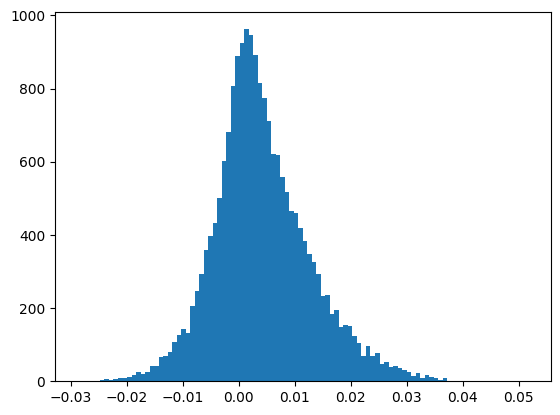

In [63]:
plt.hist(errors, bins = 100)

In [64]:
np.mean(errors)

0.004210800905178282

(array([1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        5.000e+00, 2.000e+00, 4.000e+00, 5.000e+00, 7.000e+00, 1.100e+01,
        1.300e+01, 2.000e+01, 2.300e+01, 3.400e+01, 3.700e+01, 4.200e+01,
        4.800e+01, 6.600e+01, 1.070e+02, 9.600e+01, 1.370e+02, 1.810e+02,
        2.010e+02, 2.270e+02, 2.740e+02, 3.270e+02, 3.880e+02, 4.450e+02,
        5.780e+02, 6.740e+02, 7.350e+02, 9.160e+02, 9.630e+02, 9.900e+02,
        1.005e+03, 9.950e+02, 9.240e+02, 8.480e+02, 7.960e+02, 7.230e+02,
        6.730e+02, 6.210e+02, 5.240e+02, 5.640e+02, 4.830e+02, 4.600e+02,
        4.110e+02, 3.660e+02, 3.380e+02, 2.830e+02, 2.730e+02, 2.330e+02,
        2.180e+02, 1.730e+02, 1.390e+02, 1.550e+02, 1.100e+02, 1.270e+02,
        9.800e+01, 7.800e+01, 6.300e+01, 5.900e+01, 5.300e+01, 4.500e+01,
        3.800e+01, 3.900e+01, 3.100e+01, 2.300e+01, 1.100e+01, 1.300e+01,
        9.000e+00, 1.600e+01, 8.000e+00, 5.000e+00, 2.000e+00, 5.000e+00,
        3.000e+00, 5.000e+00, 4.000e+0

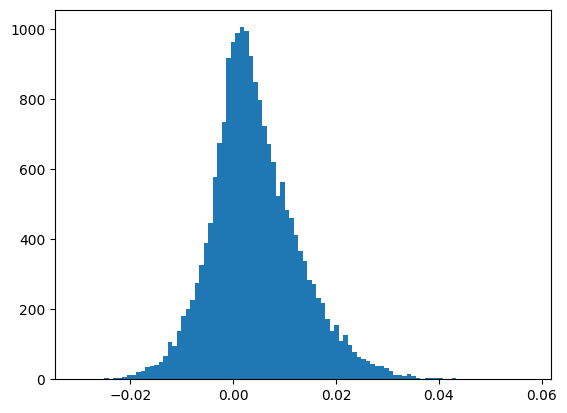

In [48]:
plt.hist(errors, bins = 100)

In [66]:
test = strategy.positions[11000000000002]

In [67]:
def simulateGames2(position, number_games = 1000):#TODO
    player_wins, dealer_wins, ties = 0, 0, 0
    dealer_card = position.dealer_face
    player_score = position.score
    draw_weights = np.array([x - y for x, y in zip([card*position.decks for card in [16, 4, 4, 4, 4, 4, 4, 4, 4, 4]], position.cards_in_play)])
    base_weights = []
    for i in range(10):
        base_weights += [10 - i]*draw_weights[i]

    base_dealer_hand = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    base_dealer_hand[10 - dealer_card] += 1

    while number_games > 0:
        temp_weights = base_weights.copy()
        dealer_hand = base_dealer_hand.copy()
        dealer_score = 0
        while dealer_score < 17:
            card = temp_weights.pop(rn.randint(0, len(temp_weights) - 1))
            dealer_hand[10 - card] += 1
            temp_weights[10 - card] -= 1
            dealer_score = score(dealer_hand)
        if player_score < 22:
            if player_score > dealer_score:
                player_wins += 1
            if player_score < dealer_score and dealer_score < 22:
                dealer_wins +=1
            if dealer_score > 21:
                player_wins +=1
            if player_score == dealer_score:
                ties += 1
        if player_score > 21:
            dealer_wins += 1

        number_games -= 1 
    return [player_wins, dealer_wins, ties]

In [84]:
final = []
running = np.array([0, 0, 0])
for i in range(1000):
    output = simulateGames2(test, 10000)
    running = running + np.array(output)
    final.append((running[0] - running[1])/sum(running))

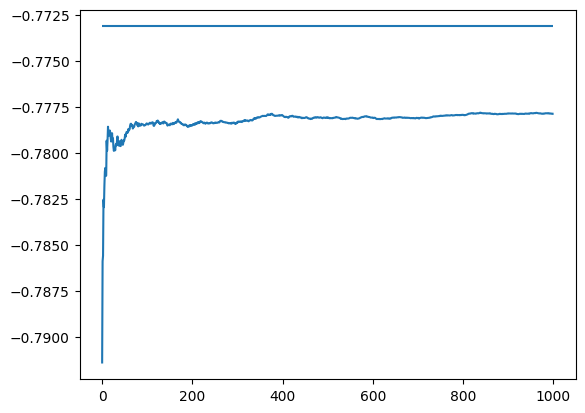

In [85]:
plt.plot(final)
plt.hlines(y = test.analytic_stick_probability, xmin = 0, xmax = 1000)

In [88]:
final[-1] - test.analytic_stick_probability

-0.00456540981467346

In [90]:
final = []
running = np.array([0, 0, 0])
for i in range(1000):
    output = simulateGames2(test, 10000)
    running = running + np.array(output)
    final.append((running[0] - running[1])/sum(running))

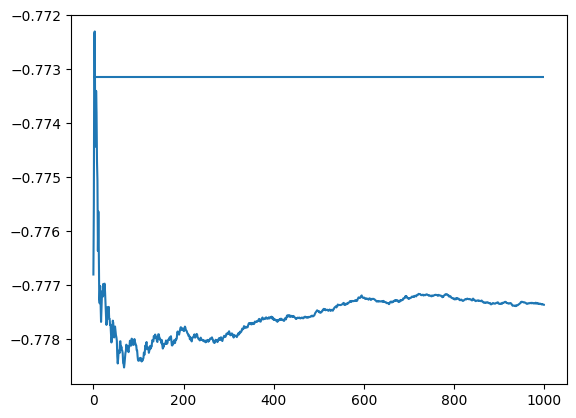

In [91]:
plt.plot(final)
plt.hlines(y = test.analytic_stick_probability, xmin = 0, xmax = 1000)

In [92]:
final[-1] - test.analytic_stick_probability

-0.004224409814673424

In [93]:
test.analytic_stick_probability

-0.7731363901853265

In [94]:
-0.771358389867353

-0.771358389867353

In [95]:
def analyticalSolution(position):
    deck_contents = deckContents(position)
    total_cards_in_deck = sum(deck_contents)
    Master = {}
    Next = {"".join(map(str, position.dealer_hand)): [position.dealer_hand, 1]}
    Depth = 0
    while len(Next) != 0:
        Current = Next.copy()
        Next = {}
        for hand_index in Current.keys():
            for drawn_card in range(1,11):
                hand = Current[hand_index][0].copy()
                comparison = hand.copy()#Improve this and next two lines :/
                comparison[10 - position.dealer_face] -= 1
                if comparison[10 - drawn_card] < deck_contents[10 - drawn_card]:
                    next_index_cards = hand.copy()
                    next_index_cards[10 - drawn_card] += 1
                    next_index = "".join(map(str, next_index_cards))
                    next_score = score(next_index_cards)
                    hand[10 - position.dealer_face] -= 1
                    if next_score < 17:
                        if next_index not in Next.keys():
                            Next[next_index] = [next_index_cards, 0]
                        Next[next_index][1] += Current[hand_index][1] * (deck_contents[10 - drawn_card] - hand[10 - drawn_card])/(total_cards_in_deck - Depth)
                    else:
                        if next_index not in Master.keys():
                            Master[next_index] = [0, next_score]
                        Master[next_index][0] += Current[hand_index][1] * (deck_contents[10 - drawn_card] - hand[10 - drawn_card])/(total_cards_in_deck - Depth)
        Depth += 1

    count = [0,0,0]
    score_outcomes = {}
    player_score = position.score
    for possible_dealer_score in range(17, 27):
        if (position.score < 22):
            if (position.score > possible_dealer_score):
                score_outcomes[possible_dealer_score] = 0
            if position.score < possible_dealer_score and possible_dealer_score < 22:
                score_outcomes[possible_dealer_score] =  1
            if (possible_dealer_score > 21):
                score_outcomes[possible_dealer_score] = 0
            if (position.score == possible_dealer_score):
                score_outcomes[possible_dealer_score] = 2
        else:
            score_outcomes[possible_dealer_score] = 1

    for check in Master.keys():
        count[score_outcomes[Master[check][1]]] += Master[check][0]

    return (count[0] - count[1])/sum(count)

In [96]:
analyticalSolution(test)

-0.7731363901853265

In [98]:
vars(test)

{'player_hand': [0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
 'dealer_hand': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 'index': 11000000000002,
 'hand_size': 10,
 'dealer_face': 1,
 'score': 12,
 'bust': False,
 'decks': 1,
 'cards_in_play': [0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
 'valid': True,
 'stick_probability': -0.7796,
 'analytic_stick_probability': -0.7731363901853265,
 'error': 0.006463609814673421}

In [97]:
-0.771358389867353

-0.771358389867353